In [2]:
!pip install kaggle


In [3]:
from google.colab import files
files.upload()  # Select your kaggle.json file


{}

In [4]:
!mkdir -p ~/.kaggle
!mv 'kaggle (2).json' ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle (2).json': No such file or directory


In [5]:
!kaggle datasets list


ref                                                          title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                      Student Performance Factors                         94KB  2024-09-02 10:53:57          31481        560  1.0              
prajwaldongre/top-100-healthiest-food-in-the-world           100 Healthiest Foods:Nutrition and Origin dataset    3KB  2024-10-11 09:40:41            924         26  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset  Mobile Device Usage and User Behavior Dataset       11KB  2024-09-28 20:21:12           4903         89  1.0              
abdulszz/spotify-most-streamed-songs                         Spotify Most Stream

In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 69% 102M/149M [00:05<00:02, 18.6MB/s]
User cancelled operation


In [7]:
!unzip brain-tumor-mri-dataset.zip -d ./brain_tumor_data/


Archive:  brain-tumor-mri-dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of brain-tumor-mri-dataset.zip or
        brain-tumor-mri-dataset.zip.zip, and cannot find brain-tumor-mri-dataset.zip.ZIP, period.


NOW WE WILL EXPLORE AND VERIFY DATASET STRUCTURE

In [8]:
import os

# Define the paths
train_path = '/content/brain_tumor_data/Training/'
test_path = '/content/brain_tumor_data/Testing/'

# List class names in Training and Testing sets
train_classes = os.listdir(train_path)
test_classes = os.listdir(test_path)

print(f"Training Classes: {train_classes}")
print(f"Testing Classes: {test_classes}")


Training Classes: ['glioma', 'notumor', 'pituitary', 'meningioma']
Testing Classes: ['glioma', 'notumor', 'pituitary', 'meningioma']


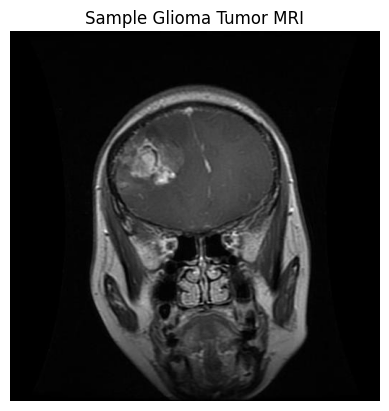

In [9]:
import cv2  # Library to read images
import matplotlib.pyplot as plt  # For visualization

# Load a sample image from the 'glioma_tumor' class
sample_image_path = train_path + 'glioma/Tr-glTr_0000.jpg'

# Read the image in grayscale
image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(image, cmap='gray')
plt.title('Sample Glioma Tumor MRI')
plt.axis('off')
plt.show()


Load And Preprocess the dataset

To train and test our model, we need to:

1. Read all images from the training and testing folders.
2. Preprocess the data by resizing and normalizing.
3. Prepare labels for classification.
4. Split the data into training and validation sets.

In [10]:
import cv2  # Library to read images
import numpy as np  # For data storage and manipulation
import os  # To navigate the file system

# Paths to the training and testing folders
train_path = '/content/brain_tumor_data/Training/'
test_path = '/content/brain_tumor_data/Testing/'

# Map each class to an integer for labeling
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

def load_data(data_dir):
    images = []
    labels = []

    # Loop through each class in the directory
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)

        # Loop through each image file in the class folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            # Read the image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Resize the image to 128x128
            img = cv2.resize(img, (128, 128))

            # Store the image and its label
            images.append(img)
            labels.append(label_map[class_name])

    # Convert the list to numpy arrays
    return np.array(images), np.array(labels)

# Load the training and testing data
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

# Print dataset information
print(f"Training Data Shape: {X_train.shape}, Labels Shape: {y_train.shape}")
print(f"Testing Data Shape: {X_test.shape}, Labels Shape: {y_test.shape}")


Training Data Shape: (5712, 128, 128), Labels Shape: (5712,)
Testing Data Shape: (1311, 128, 128), Labels Shape: (1311,)


Normalize the data

In [11]:
# Normalize the pixel values to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

print("Data normalized successfully.")


Data normalized successfully.


In [12]:
# Expand dimensions to include a channel dimension
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(f"Training Data Shape: {X_train.shape}")


Training Data Shape: (5712, 128, 128, 1)


Since this is a multi- class- classification model and problem we will one hot encode the labels

In [13]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train , num_classes=4)
y_test = to_categorical(y_test , num_classes=4)

print(f'Training Labels Shape: {y_train.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Labels Shape: (5712, 4)
Testing Labels Shape: (1311, 4)


We’ll use TensorFlow’s ImageDataGenerator to augment the data in real-time during training

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,     # Rotate images by up to 15 degrees
    width_shift_range=0.1, # Shift image horizontally by 10%
    height_shift_range=0.1,# Shift image vertically by 10%
    zoom_range=0.1,        # Random zoom by 10%
    horizontal_flip=True   # Random horizontal flip
)

# Fit the data generator on the training data
datagen.fit(X_train)


In [15]:
from sklearn.model_selection import train_test_split

# Split the data: 80% training, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training Data: {X_train.shape}, Validation Data: {X_val.shape}")


Training Data: (4569, 128, 128, 1), Validation Data: (1143, 128, 128, 1)


 Build the CNN Model from Scratch

Overview of CNN (Convolutional Neural Network)
CNNs are ideal for image-based tasks because:

Convolutional layers detect patterns (like edges, shapes, textures) in images.
Pooling layers reduce the dimensions of the data while keeping important features.
Fully connected layers make the final predictions based on extracted features.


 CNN Architecture Will Look Like This :


1. Convolutional Layers: Detect features in the MRI scans.

2. MaxPooling Layers: Reduce the spatial dimensions to prevent overfitting.

3. Dropout Layers: Regularization to avoid overfitting.

4. Flatten Layer: Converts the final feature maps to a 1D vector.

5. Dense Layers: Fully connected layers for classification.

6. Softmax Activation: Used for multi-class classification.

In [16]:
# Step 1: Import necessary libraries
import tensorflow as tf  # For building neural networks
from tensorflow.keras.models import Sequential  # Linear model construction
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Core CNN layers

# Step 2: Define the CNN model
model = Sequential([

    # 1st Convolutional Layer: Detect basic patterns (edges, textures)
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    # Explanation:
    # Conv2D applies 32 filters of size 3x3 on the input image (128x128 grayscale).
    # ReLU introduces non-linearity to the model.
    # 'input_shape=(128, 128, 1)' means the input image has height 128, width 128, and 1 channel (grayscale).

    MaxPooling2D((2, 2)),
    # Explanation:
    # MaxPooling2D reduces the size of the feature map by taking the max value from 2x2 blocks.
    # Example: A 128x128 image becomes 64x64 after 2x2 pooling.
    # Purpose: Reduces computation and helps the network focus on important features.

    # 2nd Convolutional Layer: Detect more complex patterns
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Explanation: Same as above, but with 64 filters to detect more detailed patterns.
    # The input to this layer is the pooled output of the previous Conv layer (64x64).

    # 3rd Convolutional Layer: Extract even deeper features
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Explanation: Adds more filters (128) for even more complex feature extraction.
    # After this layer, spatial size is reduced to 32x32.

    # Flatten Layer: Converts 2D feature maps into a 1D vector
    Flatten(),
    # Explanation: Takes the final pooled feature maps and flattens them into a 1D vector.
    # Example: If the input is (32x32x128), it becomes a vector of size 32*32*128 = 131072.

    # Dense Layer: Fully connected layer for learning complex patterns
    Dense(128, activation='relu'),
    Dropout(0.5),
    # Explanation:
    # Dropout randomly disables 50% of neurons during training to prevent overfitting.
    # This ensures the model doesn't rely too heavily on specific neurons.

    # Output Layer: Softmax activation for multi-class classification
    Dense(4, activation='softmax')
    # Explanation:
    # Softmax ensures the output is a probability distribution across 4 classes (no tumor, glioma, meningioma, pituitary).
])

# Step 3: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Explanation:
# 'adam' is an efficient optimizer that adjusts learning rates automatically.
# 'categorical_crossentropy' is used for multi-class classification problems.
# 'accuracy' is the evaluation metric to track during training and testing.

# Step 4: Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,580 (12.61 MB)

 Trainable params: 3,304,580 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the CNN model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Use augmented data
    epochs=10,
    validation_data=(X_val, y_val)
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


KeyboardInterrupt: 

We will increase the epochs and use Early Stopping

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping to stop training if validation accuracy doesn’t improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the CNN model with EarlyStopping
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,  # Increased epochs
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/20
 52/143 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.3535 - loss: 1.2939

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Relax the patience for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Adjusting the leaning rate

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate if validation loss doesn't improve for 3 epochs
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train with ReduceLROnPlateau and early stopping
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


OKAY, LET US PUSH THE ACCURACY MORE . WE WILL BUILD DEEPER CUSTOM CNN AND ALSO ADD BATCH NORMALISATION

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define the deeper CNN model
model = Sequential([

    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),  # Normalize after activation to stabilize training
    MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 4th Convolutional Block (deeper layer)
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully Connected Layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting

    # Output Layer: 4 classes (multi-class classification)
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the summary of the model
model.summary()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the deeper CNN model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,  # Increased epochs
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


In [ ]:
import numpy as np

# Get model predictions for the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # True labels

# Display a few test images with predictions
import matplotlib.pyplot as plt

for i in range(5):
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.title(f"True: {y_true[i]}, Predicted: {y_pred_classes[i]}")
    plt.axis('off')
    plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define the improved CNN model
model_2 = Sequential([

    # 1st Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 2nd Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 3rd Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # 4th Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Flatten the output
    Flatten(),

    # Fully connected layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to reduce overfitting

    # Output layer with softmax for multi-class classification
    Dense(4, activation='softmax')
])

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0005)  # Reduced learning rate for better convergence
model_2.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Display the model summary
model_2.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('model_2.keras', monitor='val_loss', save_best_only=True)

# Train the new model with improved settings
history = model_2.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Augmented data
    epochs=30,  # Increased epochs
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)


In [ ]:
# Load the best saved model
from tensorflow.keras.models import load_model
model_2 = load_model('model_2.keras')

# Evaluate on the test data
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


In [ ]:
# Save the custom CNN (model_2)
model_2.save('model_2.keras')  # Save in the new .keras format
print("Model_2 saved successfully!")


NOW WE WILL BUILD THE MODEL USING TRANSFER LEARNING. WE WILL IMPLEMENT TRANSFER LEARNING ON ResNet50

In [19]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

print(X_train_rgb.shape)  # Should print: (number_of_samples, 128, 128, 3)


(4569, 128, 128, 3)


In [20]:
print(f"X_train_rgb shape: {X_train_rgb.shape}")
print(f"X_val_rgb shape: {X_val_rgb.shape}")
print(f"X_test_rgb shape: {X_test_rgb.shape}")


X_train_rgb shape: (4569, 128, 128, 3)
X_val_rgb shape: (1143, 128, 128, 3)
X_test_rgb shape: (1311, 128, 128, 3)


In [21]:
# Import necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


In [22]:
# Ensure the data is in the correct shape
X_train_rgb = np.repeat(X_train, 3, axis=-1)  # Convert grayscale to RGB
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

print(f"Training data shape: {X_train_rgb.shape}")
print(f"Validation data shape: {X_val_rgb.shape}")
print(f"Test data shape: {X_test_rgb.shape}")


Training data shape: (4569, 128, 128, 3)
Validation data shape: (1143, 128, 128, 3)
Test data shape: (1311, 128, 128, 3)


In [23]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Fit the data generator to the training data
datagen.fit(X_train_rgb)


In [24]:
# Load ResNet50 without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the pre-trained layers

# Build the transfer learning model
transfer_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Safely reduces feature maps to 1D
    Dense(512, activation='relu'),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(4, activation='softmax')  # Output layer for 4-class classification
])

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.0001)
transfer_model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])





In [ ]:
history = transfer_model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val_rgb, y_val),
    callbacks=[lr_scheduler]
)


In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 without top layers and allow fine-tuning on the last few layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the last few layers to fine-tune them
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,

    # Add layers for feature extraction and classification
    GlobalAveragePooling2D(),
    BatchNormalization(),  # Normalize the layer output
    Dense(512, activation='relu'),  # More neurons for deeper learning
    Dropout(0.5),  # Prevent overfitting
    BatchNormalization(),
    Dense(256, activation='relu'),  # Another dense layer
    Dropout(0.3),
    Dense(4, activation='softmax')  # Output layer for 4-class classification
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])




In [26]:
history = model.fit(
    datagen.flow(X_train_rgb, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val_rgb, y_val),

)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 104s 334ms/step - accuracy: 0.6294 - loss: 0.9654 - val_accuracy: 0.2703 - val_loss: 2.8934
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.8883 - loss: 0.3227 - val_accuracy: 0.2695 - val_loss: 1.8630
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9235 - loss: 0.2290 - val_accuracy: 0.3307 - val_loss: 1.9401
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9470 - loss: 0.1534 - val_accuracy: 0.4164 - val_loss: 1.7976
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - accuracy: 0.9603 - loss: 0.1342 - val_accuracy: 0.4716 - val_loss: 1.5745
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9603 - loss: 0.1146 - val_accuracy: 0.4567 - val_loss: 1.9021
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9513 - loss: 0.1384 - val_accuracy: 0.7690 - val_loss: 0.7844
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - accuracy: 0.9791 - loss: 

In [27]:
test_loss, test_accuracy = model.evaluate(X_test_rgb, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.9686 - loss: 0.1050
Test Accuracy: 94.81%
Test Loss: 0.1644


In [28]:

# Save the transfer learning model
transfer_model.save('transfer_learning_model.keras')
print("Transfer learning model saved successfully!")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Transfer learning model saved successfully!


In [29]:
from tensorflow.keras.models import load_model

# Load the models from saved files
model_2 = load_model('model_2.keras')
transfer_learning_model = load_model('transfer_learning_model.keras')


In [32]:
print(f"Model_2 Input Shape: {model_2.input_shape}")



Model_2 Input Shape: (None, 128, 128, 1)


In [34]:
# Predict with model_2 using the preprocessed test data
predictions_model_2 = model_2.predict(X_test)

# Display predictions with confidence scores
for i, prediction in enumerate(predictions_model_2[:5]):
    confidence = np.max(prediction)
    predicted_class = np.argmax(prediction)
    print(f"Model_2 - Sample {i + 1}: Predicted class = {predicted_class}, Confidence = {confidence:.2f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Model_2 - Sample 1: Predicted class = 1, Confidence = 1.00
Model_2 - Sample 2: Predicted class = 1, Confidence = 0.95
Model_2 - Sample 3: Predicted class = 1, Confidence = 1.00
Model_2 - Sample 4: Predicted class = 1, Confidence = 1.00
Model_2 - Sample 5: Predicted class = 1, Confidence = 0.85


In [36]:
transfer_learning_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (32, 4, 4, 2048)            │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ [(32, 4, 4, 2048), (32, 4,  │               0 │
│ (GlobalAveragePooling2D)             │ 4, 2048)]                   │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load the ResNet50 base model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers

# Build the transfer learning model
transfer_learning_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Ensures correct pooling to a single tensor
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # Output layer for 4-class classification
])

# Compile the model
transfer_learning_model.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# Display the model summary
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load the base ResNet50 model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers to retain pre-trained weights

# Build the model step by step
transfer_learning_model = Sequential()

# Add the base ResNet model
transfer_learning_model.add(base_model)

# Add a pooling layer to flatten the output to 1D
transfer_learning_model.add(GlobalAveragePooling2D())

# Add BatchNormalization for regularization
transfer_learning_model.add(BatchNormalization())

# Add a Dense layer with ReLU activation
transfer_learning_model.add(Dense(512, activation='relu'))

# Add Dropout for further regularization
transfer_learning_model.add(Dropout(0.5))

# Add the final Dense layer with softmax activation for multi-class classification
transfer_learning_model.add(Dense(4, activation='softmax'))

# Compile the model
transfer_learning_model.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# Display the model summary
transfer_learning_model.summary()



ValueError: Undefined shapes are not supported.

In [39]:
transfer_learning_model.summary()

ValueError: Undefined shapes are not supported.

In [41]:
!pip install tensorflow --upgrade


In [42]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input

# Input layer with the correct shape for RGB images
input_layer = Input(shape=(128, 128, 3))

# Load the ResNet50 base model without the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Add GlobalAveragePooling2D to convert the 4x4x2048 output to a 1D tensor
x = GlobalAveragePooling2D()(base_model.output)

# Add BatchNormalization
x = BatchNormalization()(x)

# Add a Dense layer with ReLU activation
x = Dense(512, activation='relu')(x)

# Add Dropout for regularization
x = Dropout(0.5)(x)

# Add the final Dense layer with softmax activation for multi-class classification
output_layer = Dense(4, activation='softmax')(x)

# Create the full model
transfer_learning_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
transfer_learning_model.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

# Display the model summary to verify everything
transfer_learning_model.summary()


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,647,044 (94.02 MB)

 Trainable params: 24,589,828 (93.80 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [43]:
# Assign a new name to the transfer learning model
transfer_learning_model_v2 = transfer_learning_model

# Save the model with a proper name
transfer_learning_model_v2.save('transfer_learning_model_v2.keras')
print("Model saved successfully!")


Model saved successfully!


In [45]:
# Compile the model with optimizer, loss, and metrics
from tensorflow.keras.optimizers import Adam

transfer_learning_model_v2.compile(
    optimizer=Adam(learning_rate=1e-4),  # Adjust learning rate as needed
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model on training data
history = transfer_learning_model_v2.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,  # Set to more epochs if needed
    batch_size=32,
    verbose=1
)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 290ms/step - accuracy: 0.7801 - loss: 0.6311 - val_accuracy: 0.2703 - val_loss: 2.8037
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.9550 - loss: 0.1281 - val_accuracy: 0.2703 - val_loss: 3.0201
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.9814 - loss: 0.0501 - val_accuracy: 0.2703 - val_loss: 2.4747
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.9871 - loss: 0.0383 - val_accuracy: 0.2843 - val_loss: 3.1827
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.9920 - loss: 0.0265 - val_accuracy: 0.5311 - val_loss: 1.5510
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 115ms/step - accuracy: 0.9872 - loss: 0.0369 - val_accuracy: 0.6597 - val_loss: 1.2382
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.9830 - loss: 0.0487 - val_accuracy: 0.8521 - val_loss: 0.4308
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 116ms/step - accuracy: 0.9912 - loss: 0

In [46]:
# Evaluate the model on test data
test_loss, test_accuracy = transfer_learning_model_v2.evaluate(X_test_rgb, y_test, verbose=1)

# Print the test results
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9601 - loss: 0.1579
Test Accuracy: 97.48%
Test Loss: 0.1000


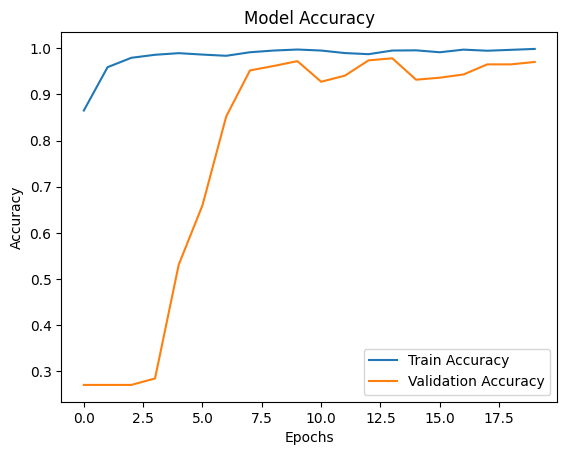

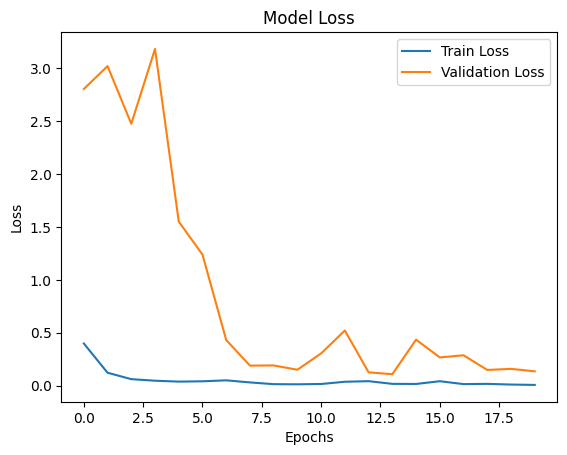

In [47]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [48]:
import numpy as np

# Make predictions on the test data
predictions = transfer_learning_model_v2.predict(X_test_rgb)

# Display predictions with confidence scores
for i, prediction in enumerate(predictions[:10]):  # Display first 10 predictions
    predicted_class = np.argmax(prediction)  # Get the class with the highest probability
    confidence_score = np.max(prediction)  # Get the highest probability (confidence)

    print(f"Sample {i + 1}: Predicted Class = {predicted_class}, "
          f"Confidence Score = {confidence_score * 100:.2f}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step
Sample 1: Predicted Class = 1, Confidence Score = 100.00%
Sample 2: Predicted Class = 1, Confidence Score = 100.00%
Sample 3: Predicted Class = 1, Confidence Score = 100.00%
Sample 4: Predicted Class = 1, Confidence Score = 100.00%
Sample 5: Predicted Class = 1, Confidence Score = 100.00%
Sample 6: Predicted Class = 1, Confidence Score = 99.07%
Sample 7: Predicted Class = 1, Confidence Score = 100.00%
Sample 8: Predicted Class = 1, Confidence Score = 100.00%
Sample 9: Predicted Class = 2, Confidence Score = 81.01%
Sample 10: Predicted Class = 1, Confidence Score = 100.00%


In [49]:
from sklearn.metrics import classification_report

# Get predicted classes
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print precision, recall, and F1-score
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Glioma', 'Meningioma', 'Pituitary']))


              precision    recall  f1-score   support

    No Tumor       0.99      1.00      0.99       405
      Glioma       0.99      0.93      0.96       300
  Meningioma       0.93      0.96      0.95       306
   Pituitary       0.99      1.00      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.97      0.97      1311



NOW WE WILL INTEGRATE THE MODEL WITH GRADIO AND BUILD IT FURTHER ( UI COMPONENTS)

In [50]:
pip install tensorflow gradio opencv-python-headless requests matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2

In [58]:
from tensorflow.keras.models import load_model

# Load the saved models
transfer_model = load_model('transfer_model_v2.keras')
custom_cnn_model = load_model('custom_cnn_model.keras')

print("Transfer Learning Model Loaded")
print("Custom CNN Model Loaded")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 438 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Transfer Learning Model Loaded
Custom CNN Model Loaded


In [59]:
import cv2
import numpy as np

# Load a sample test image (replace 'sample.jpg' with your test image path)
test_image_path = "image(7).jpg"
image = cv2.imread(test_image_path)

# Resize and preprocess image for both models
transfer_image = cv2.resize(image, (128, 128)) / 255.0  # Normalize
transfer_image = np.expand_dims(transfer_image, axis=0)  # Add batch dimension

custom_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
custom_image = cv2.resize(custom_image, (128, 128)) / 255.0
custom_image = np.expand_dims(custom_image, axis=(0, -1))  # Batch and channel dims

print("Images loaded and preprocessed.")


Images loaded and preprocessed.


In [60]:
# Transfer Learning Model Prediction
transfer_prediction = transfer_model.predict(transfer_image)[0]
transfer_class = np.argmax(transfer_prediction)
transfer_confidence = np.max(transfer_prediction)

print(f"Transfer Model Prediction: {transfer_class} with Confidence: {transfer_confidence:.2f}")

# Custom CNN Model Prediction
custom_prediction = custom_cnn_model.predict(custom_image)[0]
custom_class = np.argmax(custom_prediction)
custom_confidence = np.max(custom_prediction)

print(f"Custom CNN Prediction: {custom_class} with Confidence: {custom_confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Transfer Model Prediction: 0 with Confidence: 0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Custom CNN Prediction: 0 with Confidence: 0.76


In [61]:
class_names = ["Meningioma", "Glioma", "Pituitary", "No Tumor"]

print(f"Transfer Model: {class_names[transfer_class]} with Confidence {transfer_confidence:.2f}")
print(f"Custom CNN Model: {class_names[custom_class]} with Confidence {custom_confidence:.2f}")


Transfer Model: Meningioma with Confidence 0.53
Custom CNN Model: Meningioma with Confidence 0.76


In [62]:
# Load the models again to inspect them
from tensorflow.keras.models import load_model

transfer_model = load_model('transfer_model_v2.keras')
custom_cnn_model = load_model('custom_cnn_model.keras')

# Print the summary of both models
print("Transfer Learning Model Summary:")
transfer_model.summary()

print("\nCustom CNN Model Summary:")
custom_cnn_model.summary()


Transfer Learning Model Summary:


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 73,826,702 (281.63 MB)

 Trainable params: 24,589,828 (93.80 MB)

 Non-trainable params: 57,216 (223.50 KB)

 Optimizer params: 49,179,658 (187.61 MB)


Custom CNN Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,330,830 (58.48 MB)

 Trainable params: 5,109,956 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 10,219,914 (38.99 MB)

In [66]:
import numpy as np
from tensorflow.keras.models import load_model
import cv2

# Load the models
transfer_model = load_model('transfer_model_v2.keras')
custom_cnn_model = load_model('custom_cnn_model.keras')

# Preprocess image based on model type
def preprocess_image(image, model_type):
    image = cv2.resize(image, (128, 128))  # Resize to (128, 128)

    # Ensure the image is in uint8 format for OpenCV
    image = np.array(image, dtype=np.uint8)

    if model_type == "Transfer Learning":
        # Convert grayscale to RGB if needed
        if len(image.shape) == 2 or image.shape[-1] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif model_type == "Custom CNN":
        # Convert RGB to grayscale if needed
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = np.expand_dims(image, axis=-1)  # Add channel dimension

    # Normalize the image
    image = image / 255.0
    return np.expand_dims(image, axis=0)  # Add batch dimension

# Predict function
def predict_tumor(image, model_type):
    if model_type == "Transfer Learning":
        model = transfer_model
    else:
        model = custom_cnn_model

    preprocessed_image = preprocess_image(image, model_type)
    prediction = model.predict(preprocessed_image)

    class_names = ["Meningioma", "Glioma", "Pituitary", "No Tumor"]
    predicted_class = class_names[np.argmax(prediction)]
    confidence_score = np.max(prediction)

    return predicted_class, confidence_score


In [67]:
# Test with a sample image from the dataset
sample_image = X_test[0]  # Replace with valid test image

# Test Transfer Learning model
pred_class, conf_score = predict_tumor(sample_image, "Transfer Learning")
print(f"Transfer Learning Prediction: {pred_class}, Confidence: {conf_score:.2f}")

# Test Custom CNN model
pred_class, conf_score = predict_tumor(sample_image, "Custom CNN")
print(f"Custom CNN Prediction: {pred_class}, Confidence: {conf_score:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Transfer Learning Prediction: Meningioma, Confidence: 0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Custom CNN Prediction: Meningioma, Confidence: 0.99
